# Tutorial: Deploy an image classification model in Azure Container Instances

### Set up the environment

Start by setting up a testing environment.

Import packages
Import the Python packages needed for this tutorial:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
 
import azureml
from azureml.core import Workspace, Run

# Display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.83


### Retrieve the model

You registered a model in your workspace in the previous tutorial. Now load this workspace and download the model to your local directory:

In [2]:
from azureml.core import Workspace
from azureml.core.model import Model
import os
ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')

model.download(target_dir=os.getcwd(), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "sklearn_mnist_model.pkl")

os.stat(file_path)

os.stat_result(st_mode=33206, st_ino=8162774325855967, st_dev=908635441, st_nlink=1, st_uid=0, st_gid=0, st_size=63683, st_atime=1579571549, st_mtime=1579571549, st_ctime=1579571549)

### Test the model locally

Before you deploy, make sure your model is working locally:

* Load test data.
* Predict test data.
* Examine the confusion matrix.

### Load test data

Load the test data from the ./data/ directory created during the training tutorial:

In [3]:
import os
import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays

def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array

def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

data_folder = os.path.join(os.getcwd(), 'data')

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster

X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / 255.0
y_test = load_data(os.path.join(
    data_folder, 't10k-labels-idx1-ubyte.gz'), True).reshape(-1)

### Predict test data

To get predictions, feed the test dataset to the model:

In [4]:
import pickle
from sklearn.externals import joblib

clf = joblib.load(os.path.join(os.getcwd(), 'sklearn_mnist_model.pkl'))
y_hat = clf.predict(X_test)

c:\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Examine the confusion matrix

Generate a confusion matrix to see how many samples from the test set are classified correctly. Notice the misclassified value for the incorrect predictions:

In [5]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    4    4    3  913    0   10    3    5   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]
Overall accuracy: 0.9193


Use matplotlib to display the confusion matrix as a graph. In this graph, the x-axis shows the actual values, and the y-axis shows the predicted values. The color in each grid shows the error rate. The lighter the color, the higher the error rate is. For example, many 5's are misclassified as 3's. So you see a bright grid at (5,3):

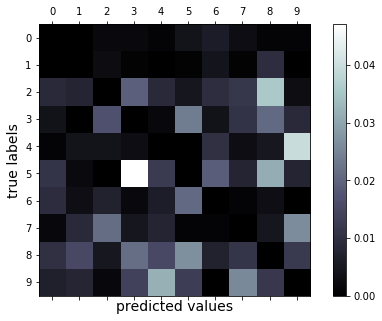

In [6]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

### Deploy as a web service

After you tested the model and you're satisfied with the results, deploy the model as a web service hosted in Container Instances.

To build the correct environment for Container Instances, provide the following components:

* A scoring script to show how to use the model.
* An environment file to show what packages need to be installed.
* A configuration file to build the container instance.
* The model you trained previously.

### Create scoring script
Create the scoring script, called score.py. The web service call uses this script to show how to use the model.

Include these two required functions in the scoring script:

* The init() function, which typically loads the model into a global object. This function is run only once when the Docker container is started.

* The run(input_data) function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported.

In [7]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Writing score.py


### Create environment file

Next create an environment file, called myenv.yml, that specifies all of the script's package dependencies. This file is used to make sure that all of those dependencies are installed in the Docker image. This model needs scikit-learn and azureml-sdk. All custom environment files need to list azureml-defaults with verion >= 1.0.45 as a pip dependency. This package contains the functionality needed to host the model as a web service.

In [8]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")
myenv.add_pip_package("azureml-defaults")

with open("myenv.yml", "w") as f:
    f.write(myenv.serialize_to_string())

Review the content of the myenv.yml file:

In [9]:
with open("myenv.yml", "r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will

# be automatically provisioned for runs with userManagedDependencies=False.


# Details about the Conda environment file format:

# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually


name: project_environment
dependencies:
  # The python interpreter version.

  # Currently Azure ML only supports 3.5.2 and later.

- python=3.6.2

- pip:
  - azureml-defaults
- scikit-learn
channels:
- conda-forge



### Create a configuration file

Create a deployment configuration file. Specify the number of CPUs and gigabytes of RAM needed for your Container Instances container. Although it depends on your model, the default of one core and 1 gigabyte of RAM is sufficient for many models. If you need more later, you have to re-create the image and redeploy the service.

In [10]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  
                                                     "method": "sklearn"},
                                               description='Predict MNIST with sklearn')

### Deploy in Container Instances

The estimated time to finish deployment is about seven to eight minutes.

Configure the image and deploy. The following code goes through these steps:

1. Build an image by using these files:
    * The scoring file, score.py.
    * The environment file, myenv.yml.
    * The model file.
2. Register the image under the workspace.
3. Send the image to the Container Instances container.
4. Start up a container in Container Instances by using the image.
5. Get the web service HTTP endpoint.

Please note that if you are defining your own environment file, you must list azureml-defaults with version >= 1.0.45 as a pip dependency. This package contains the functionality needed to host the model as a web service.

In [11]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment

myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

service = Model.deploy(workspace=ws,
                       name='sklearn-mnist-svc',
                       models=[model], 
                       inference_config=inference_config,
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Running.......................................................................................................................................................................................................................................
TimedOut


ERROR - Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 5b4d6500-2dcf-43fa-abf1-9330dfc465d9
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. From SDK you can run print(service.state) to know the current state of the webservice."
}

ERROR - Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 5b4d6500-2dcf-43fa-abf1-9330dfc465d9
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking longer than our n

WebserviceException: WebserviceException:
	Message: Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 5b4d6500-2dcf-43fa-abf1-9330dfc465d9
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. From SDK you can run print(service.state) to know the current state of the webservice."
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Service deployment polling reached non-successful terminal state, current service state: Unhealthy\nOperation ID: 5b4d6500-2dcf-43fa-abf1-9330dfc465d9\nMore information can be found using '.get_logs()'\nError:\n{\n  \"code\": \"DeploymentTimedOut\",\n  \"statusCode\": 504,\n  \"message\": \"The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. From SDK you can run print(service.state) to know the current state of the webservice.\"\n}"
    }
}

Get the scoring web service's HTTP endpoint, which accepts REST client calls. You can share this endpoint with anyone who wants to test the web service or integrate it into an application:

In [12]:
print(service.scoring_uri)

http://fc50b8a5-a504-40a6-90ba-e0c6f64e9a1f.eastus.azurecontainer.io/score


### Test the deployed service

Earlier, you scored all the test data with the local version of the model. Now you can test the deployed model with a random sample of 30 images from the test data.

The following code goes through these steps:

1. Send the data as a JSON array to the web service hosted in Container Instances.

2. Use the SDK's run API to invoke the service. You can also make raw calls by using any HTTP tool such as curl.

3. Print the returned predictions and plot them along with the input images. Red font and inverse image, white on black, is used to highlight the misclassified samples.

Because the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample:

In [ ]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

You can also send a raw HTTP request to test the web service:

In [ ]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

In [ ]:
### Clean up resources

To keep the resource group and workspace for other tutorials and exploration, you can delete only the Container Instances deployment by using this API call:

In [ ]:
service.delete()